# Implementation - Belief Propagation

In [1]:
import numpy  as np
import igraph as ig

import matplotlib.pyplot as plt
plt.rc("text", usetex=True)

%run ./2-ImplementationFactor.ipynb
%run ./3-ImplementationPGM.ipynb

## 1 BP


We create a class ```belief_propagation``` and store messages in ```self.__msg ``` since they can be reused in further calculations. Also there is ```self.__pgm``` field for a factor graph.

Note, that we normalize each message in order to avoid numerical underflow/overflow.

In [2]:
class belief_propagation():
    def __init__(self, pgm):
        if type(pgm) is not factor_graph:
            raise Exception('PGM is not a factor graph')
        if not (pgm.is_connected() and not pgm.is_loop()):
            raise Exception('PGM is not a tree')
        
        self.__msg = {}
        self.__pgm = pgm
    
    def belief(self, v_name):
        incoming_messages = []
        for f_name_neighbor in self.__pgm.get_graph().vs[self.__pgm.get_graph().neighbors(v_name)]['name']:
            incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        return self.__normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Variable to factor ------------
    def get_variable2factor_msg(self, v_name, f_name):
        key = (v_name, f_name)
        if key not in self.__msg:
            self.__msg[key] = self.__compute_variable2factor_msg(v_name, f_name)
        return self.__msg[key]
    
    def __compute_variable2factor_msg(self, v_name, f_name):
        incoming_messages = []
        for f_name_neighbor in self.__pgm.get_graph().vs[self.__pgm.get_graph().neighbors(v_name)]['name']:
            if f_name_neighbor != f_name:
                incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        
        if not incoming_messages:
            # if the variable does not have its own distribution
            return factor([v_name], np.array([1.]*self.__pgm.get_graph().vs.find(name=v_name)['rank']))
        else:
            # Since all messages have the same dimension (1, order of v_name) the expression after
            # ```return``` is equivalent to ```factor(v_name, np.prod(incoming_messages))```
            return self.__normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Factor to variable ------------
    def get_factor2variable_msg(self, f_name, v_name):
        key = (f_name, v_name)
        if key not in self.__msg:
            self.__msg[key] = self.__compute_factor2variable_msg(f_name, v_name)
        return self.__msg[key]
    
    def __compute_factor2variable_msg(self, f_name, v_name):
        incoming_messages = [self.__pgm.get_graph().vs.find(f_name)['factor_']]
        marginalization_variables = []
        for v_name_neighbor in self.__pgm.get_graph().vs[self.__pgm.get_graph().neighbors(f_name)]['name']:
            if v_name_neighbor != v_name:
                incoming_messages.append(self.get_variable2factor_msg(v_name_neighbor, f_name))
                marginalization_variables.append(v_name_neighbor)
        return self.__normalize_msg(factor_marginalization(
            joint_distribution(incoming_messages),
            marginalization_variables
        ))
    
    # ----------------------- Other -------------------------
    def __normalize_msg(self, message):
        return factor(message.get_variables(), message.get_distribution()/np.sum(message.get_distribution()))

#### Example

Let's take a look at the following factor graph.

![](./img/4/1.1.png)

In [3]:
mrf = string2factor_graph('f1(a,b)f2(b,c,d)f3(c)')

In [4]:
f1 = factor(['a', 'b'],      np.array([[2,3],[6,4]]))
f2 = factor(['b', 'd', 'c'], np.array([[[7,2,3],[1,5,2]],[[8,3,9],[6,4,2]]]))
f3 = factor(['c'],           np.array([5, 1, 9]))

In [5]:
mrf.change_factor_distribution('f1', f1)
mrf.change_factor_distribution('f2', f2)
mrf.change_factor_distribution('f3', f3)

Run the algorithm to compute marginal distribution of ```b```

In [6]:
bp = belief_propagation(mrf)
bp.belief('b').get_distribution()

array([0.37398374, 0.62601626])

---

## 2 Loopy BP

In [7]:
class loopy_belief_propagation():
    def __init__(self, pgm):
        if type(pgm) is not factor_graph:
            raise Exception('PGM is not a factor graph')
        if not pgm.is_connected():
            raise Exception('PGM is not connected')
        if len(pgm.get_graph().es) - 1 == len(pgm.get_graph().vs):
            raise Exception('PGM is a tree')
        
        self.__t       = 0
        self.__msg     = {}
        self.__msg_new = {}
        self.__pgm     = pgm
        
        # Initialization of messages
        for edge in self.__pgm.get_graph().es:
            start_index, end_index = edge.tuple[0], edge.tuple[1]
            start_name, end_name = self.__pgm.get_graph().vs[start_index]['name'], self.__pgm.get_graph().vs[end_index]['name']
            
            if self.__pgm.get_graph().vs[start_index]['is_factor']:
                self.__msg[(start_name, end_name)] = factor([end_name],   np.array([1.]*self.__pgm.get_graph().vs[end_index]['rank']))
            else:
                self.__msg[(start_name, end_name)] = factor([start_name], np.array([1.]*self.__pgm.get_graph().vs[start_index]['rank']))
            self.__msg[(end_name, start_name)] = self.__msg[(start_name, end_name)]
            
            self.__msg_new[(start_name, end_name)] = 0
            self.__msg_new[(end_name, start_name)] = 0
    
    def belief(self, v_name, num_iter):
        if self.__t > num_iter:
            raise Exception('Invalid number of iterations. Current number: ' + str(self.__t))
        elif self.__t < num_iter:
            self.__loop(num_iter)
        
        incoming_messages = []
        for f_name_neighbor in self.__pgm.get_graph().vs[self.__pgm.get_graph().neighbors(v_name)]['name']:
            incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        return self.__normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Variable to factor ------------
    def get_variable2factor_msg(self, v_name, f_name):
        return self.__msg[(v_name, f_name)]
    
    def __compute_variable2factor_msg(self, v_name, f_name):
        incoming_messages = []
        for f_name_neighbor in self.__pgm.get_graph().vs[self.__pgm.get_graph().neighbors(v_name)]['name']:
            if f_name_neighbor != f_name:
                incoming_messages.append(self.get_factor2variable_msg(f_name_neighbor, v_name))
        
        if not incoming_messages:
            return factor([v_name], np.array([1]*self.__pgm.get_graph().vs.find(name=v_name)['rank']))
        else:
            return self.__normalize_msg(joint_distribution(incoming_messages))
    
    # ----------------------- Factor to variable ------------
    def get_factor2variable_msg(self, f_name, v_name):
        return self.__msg[(f_name, v_name)]
    
    def __compute_factor2variable_msg(self, f_name, v_name):
        incoming_messages = [self.__pgm.get_graph().vs.find(f_name)['factor_']]
        marginalization_variables = []
        for v_name_neighbor in self.__pgm.get_graph().vs[self.__pgm.get_graph().neighbors(f_name)]['name']:
            if v_name_neighbor != v_name:
                incoming_messages.append(self.get_variable2factor_msg(v_name_neighbor, f_name))
                marginalization_variables.append(v_name_neighbor)
        return self.__normalize_msg(factor_marginalization(
            joint_distribution(incoming_messages),
            marginalization_variables
        ))
    
    # ----------------------- Other -------------------------
    def __loop(self, num_iter):
        # Message updating
        while self.__t < num_iter:
            for edge in self.__pgm.get_graph().es:
                start_index, end_index = edge.tuple[0], edge.tuple[1]
                start_name, end_name   = self.__pgm.get_graph().vs[start_index]['name'], self.__pgm.get_graph().vs[end_index]['name']

                if self.__pgm.get_graph().vs[start_index]['is_factor']:
                    self.__msg_new[(start_name, end_name)] = self.__compute_factor2variable_msg(start_name, end_name)
                    self.__msg_new[(end_name, start_name)] = self.__compute_variable2factor_msg(end_name, start_name)
                else:
                    self.__msg_new[(start_name, end_name)] = self.__compute_variable2factor_msg(start_name, end_name)
                    self.__msg_new[(end_name, start_name)] = self.__compute_factor2variable_msg(end_name, start_name)
            self.__msg.update(self.__msg_new)
            self.__t += 1
    
    def __normalize_msg(self, message):
        return factor(message.get_variables(), message.get_distribution()/np.sum(message.get_distribution()))

#### Example

Let's consider the following factor graph with a loop.

![](./img/4/1.2.png)

In [8]:
mrf = string2factor_graph('f1(a,b)f2(a,c)f3(b,c)')

In [9]:
f1 = factor(['a', 'b'],  np.array([[2,3],[6,4]]))
f2 = factor(['a', 'c'],  np.array([[7,2,3],[1,5,2]]))
f3 = factor(['b', 'c'],  np.array([[7,9,3],[6,4,2]]))

In [10]:
mrf.change_factor_distribution('f1', f1)
mrf.change_factor_distribution('f2', f2)
mrf.change_factor_distribution('f3', f3)

Firstly, let's compute exact marginal distribution of `b` and normalize it.

In [14]:
exact = factor_marginalization(joint_distribution([f1, f2, f3]), ['a', 'c']).get_distribution()
exact = exact / np.sum(exact)
exact

array([0.63451777, 0.36548223])

Secondly, we run the loopy belief propagation algorithm.

In [15]:
lbp = loopy_belief_propagation(mrf)
tol = []

for i in range(15):
    tol.append(np.linalg.norm(lbp.belief('b', i).get_distribution() - exact))

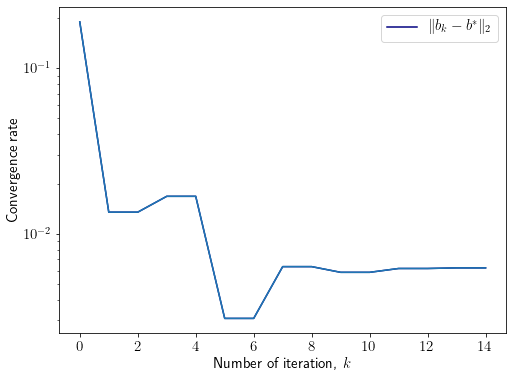

In [16]:
plt.figure(figsize=(8,6))
plt.semilogy(tol, label=r"$\|b_k - b^*\|_2$", color='navy')
plt.xlabel(r"Number of iteration, $k$", fontsize=15)
plt.ylabel(r"Convergence rate", fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc="best", fontsize=15)
plt.plot(tol)